# Evaluation of Different Hyperparameter Tuning Methods
- ### Grid Search
- ### Particle Swarm
- ### Genetic Algorithm

In [14]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pandas as pd
import time
from tqdm import tqdm 
from mpl_toolkits.mplot3d import Axes3D 


from sklearn import svm
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.datasets import make_circles 
from sklearn.datasets import make_blobs
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

#use modified genetic algorithm for experiment purpose
#from geneticalgorithm import geneticalgorithm as ga
#%run ModifiedGA.ipynb

import warnings
warnings.filterwarnings("ignore")

## Part 1: Method Implementation

In [12]:
'''GridSearch'''
def grid_search(X,y, c_choices,gamma_choices,cv=5,plot=False):
    min_error=math.inf
    best_c=0
    best_gamma=0
    
    error_list=[]
    param_list=[]
    clf_list=[]
    
    #timer pt1
    time_elapsed=0    
    time_start = time.perf_counter()
    
    #iterate through choice of hyperparameters
    for cur_c in c_choices:
        
        for cur_gamma in gamma_choices:
                        
            #update svm with new hyperparameters
            clf = svm.SVC(kernel='rbf',C=cur_c,gamma=cur_gamma)
            
            #check if current hyperparameters improve
            cur_error=1-np.mean(cross_val_score(clf, X, y, cv=cv))
            if cur_error < min_error:
                min_error=cur_error
                best_c = cur_c
                best_gamma=cur_gamma
            
            #to_return
            cur_pair=[cur_c,cur_gamma]
            param_list.append(cur_pair)
            clf_list.append(clf)
            error_list.append(cur_error)
                
    #timer pt2
    time_elapsed = (time.perf_counter() - time_start)
                
    #make heatmap (reverse color ,cmap = sns.cm.rocket_r)
    if plot:
        error_mtrx=np.asarray(error_list).reshape((len(c_choices),len(gamma_choices)))
        ax = sns.heatmap(error_mtrx,yticklabels=c_choices.round(3),xticklabels=gamma_choices.round(3),cmap = sns.cm.rocket_r)
        plt.xlabel("Gamma") 
        plt.ylabel("Cost") 
        ax.set_title('Prediction Error Heatmap')
        
    return {'params': param_list, 'final_error':min_error,'error_list':error_list,'clfs':clf_list,'run_time':time_elapsed,'best_params':[best_c,best_gamma]}

In [36]:
''' Particle Swarm '''
def particle_swarm(X,y,cv=0,plot=False):

    # turn (cv) error function into objective function
    # all particles passed in obj_fun, need to loop through params for individual particle
    def obj_func(params):
        to_return=[]
        for i in range(len(params)):  
            cur_c=params[i][0]
            cur_gamma=params[i][1]

            clf = svm.SVC(kernel='rbf', C=cur_c, gamma=cur_gamma)
            clf.fit(X, y)
            to_return.append(1-clf.score(X, y))
            
        return to_return
    
    def obj_func_cv(params):
        to_return=[]
        for i in range(len(params)):  
            cur_c=params[i][0]
            cur_gamma=params[i][1]

            clf = svm.SVC(kernel='rbf', C=cur_c, gamma=cur_gamma)
            avg=np.mean(cross_val_score(clf, X, y, cv=cv))
            to_return.append(1-avg)
      
        return to_return

    time_start = time.perf_counter()
    
    # set boundaries
    max_bound = 10* np.ones(2)
    min_bound = 0.0001*np.ones(2)

    #max_bound = np.array([2**15,2**15])
    #min_bound = np.array([2**-11,2**-11])

    bounds = (min_bound, max_bound)
    
    # instatiate the optimizer
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
    optimizer = GlobalBestPSO(n_particles=5, dimensions=2, options=options,bounds=bounds)
    if cv!=0:
        obj_func=obj_func_cv
    
    time_start = time.perf_counter()

    cost, pos = optimizer.optimize(obj_func, iters=20,verbose=False)
    
    time_elapsed = (time.perf_counter() - time_start)
    
    #plot algorithm convergence curve
    if plot:
        plot_cost_history(cost_history=optimizer.cost_history)
        plt.show()
    
    return {'params': pos, 'final_error':cost,'error_list':optimizer.cost_history,'run_time':time_elapsed}

In [37]:
'''Genetic Algorithm'''
def genetic_algorithm(X,y,cv=0,plot=False,progress_bar=False):

    # turn (cv) error function into objective function
    #oppose to PSO, no need to loop, every point is called once
    def obj_func(params):      
        cur_c=params[0]
        cur_gamma=params[1]

        clf = svm.SVC(kernel='rbf', C=cur_c, gamma=cur_gamma)
        clf.fit(X, y)
        
        return 1-clf.score(X, y)
    
    def obj_func_cv(params):
        cur_c=params[0]
        cur_gamma=params[1]

        clf = svm.SVC(kernel='rbf', C=cur_c, gamma=cur_gamma)   
        
        avg=np.mean(cross_val_score(clf, X, y, cv=cv))
        
        return 1-avg
    
    time_start = time.perf_counter()
    
    algorithm_param = {'max_num_iteration': 20,\
                       'population_size':5,\
                       'mutation_probability':0.1,\
                       'elit_ratio': 0.01,\
                       'crossover_probability': 0.5,\
                       'parents_portion': 0.3,\
                       'crossover_type':'uniform',\
                       'max_iteration_without_improv':None}

    # set boundaries
    varbound=np.array([[0.0001,10]]*2)
    #varbound=np.array([[2**-11,2**15],[2**-11,2**15]])

    if cv!=0:
        obj_func=obj_func_cv
        
    model=geneticalgorithm(function=obj_func,dimension=2,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param, convergence_curve=plot,progress_bar=progress_bar,print_results=False)

    model.run()
        
    time_elapsed = (time.perf_counter() - time_start)
    
    #this print parameters of the genetic algorithm
    #model.param
    
    #this prints the final output in dictionary ["variable"], ["function"]
    #model.output_dict
    
    #this stores the error at each iteration
    #model.report

    return {'params': model.output_dict['variable'], 'final_error':model.output_dict['function'],'error_list':model.report,'run_time':time_elapsed}    

## Part 2: Generate Synthetic Data


#### 1. Use "Boundary"
- Define a function as "boundary"
- Label points accordingly with randomness
- Plot data and boundary


In [19]:
#function served as general boundary
def func(x):
    #return x**3
    return -2+10*math.sin(0.2*x)+2*x+random.randrange(-2,2)

#generate label
def random_label(x_s, y_s,random=True):
    epsilon=85

    if random:
        temp_labels=[(j>func(i)) for i, j in zip(x_s, y_s)]
        for i in range(len(temp_labels)):
            if temp_labels[i]==1 and np.random.uniform(0,100)>epsilon:
                temp_labels[i]=0
            elif temp_labels[i]==0 and np.random.uniform(0,100)>epsilon:
                temp_labels[i]=1
                
    return temp_labels

def pure_random_label(n):
    to_return=[]
    for i in range(n):
        to_return.append(random.randint(0, 1))
    return to_return

In [20]:
def my_generate(num_points):
    x_s=np.random.uniform(-50,50,num_points).tolist()
    y_s=np.random.uniform(-50,50,num_points).tolist()

    # combine x and y
    a=np.asarray(x_s+y_s).reshape((2,num_points))

    # create label
    labels=random_label(x_s,y_s)
    #labels=too_random_label(num_points)

    #plot datapoints
    labels=list(map(int, labels))

    return a.T, labels

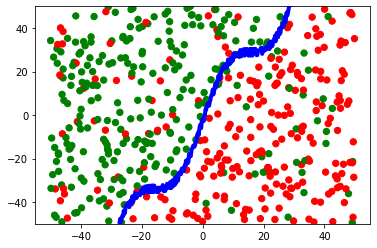

In [21]:
# generate datapoint
num_points=500
X,Y = my_generate(num_points)

a=X.T
labels=Y
colormap = np.array(['r', 'g'])
plt.scatter(a[0], a[1], s=40, c=colormap[labels])

#plot boundary 
x = np.linspace(-50,50,num_points)
y=[func(cur_x) for cur_x in x]
plt.ylim(-50, 50)
plt.plot(x,y, 'blue',linewidth=4.0)

# show the plot
plt.show()

#### 2. Use Build in Function Random Points
- sklearn make_classification

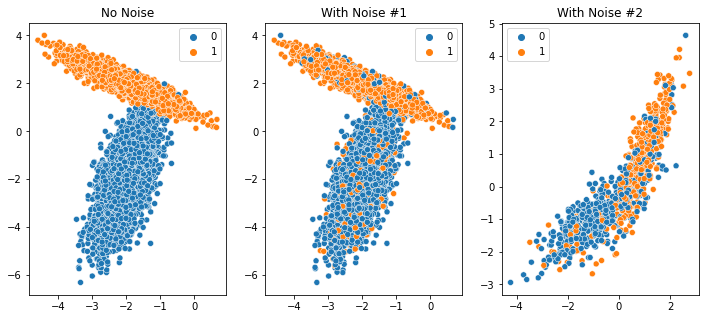

In [5]:
#https://towardsdatascience.com/https-medium-com-faizanahemad-generating-synthetic-classification-data-using-scikit-1590c1632922
import numexpr as ne
ne.set_num_threads(1)
import warnings
warnings.filterwarnings('ignore')
# Generate Clean data

X,y = make_classification(n_samples=10000, n_features=2, n_informative=2,n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,class_sep=2,flip_y=0,weights=[0.5,0.5], random_state=17)
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(12,5))
sns.scatterplot(X[:,0],X[:,1],hue=y,ax=ax1);
ax1.set_title("No Noise");

# Generate noisy Data
X,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,class_sep=2,flip_y=0.2,weights=[0.5,0.5], random_state=17)
sns.scatterplot(X[:,0],X[:,1],hue=y,ax=ax2);
ax2.set_title("With Noise #1");

X,y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,class_sep=1,flip_y=0.3,weights=[0.5,0.5], random_state=16)
#f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
sns.scatterplot(X[:,0],X[:,1],hue=y);
ax3.set_title("With Noise #2");
plt.show();

#### 3. Use Build in Function Circle Points
- sklearn make_circles

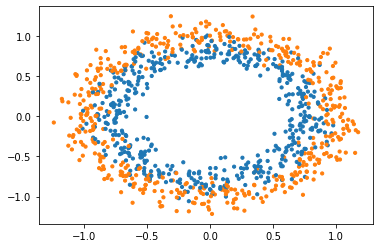

In [6]:
# generating data 
X, Y = make_circles(n_samples = 1000, noise = 0.1)
  
# visualizing data 
colormap = np.array(['tab:orange', 'tab:blue'])
plt.scatter(X[:, 0], X[:, 1], c=colormap[Y], marker = '.', s=40) 
plt.show() 

## Part 3: Experiment


### Helper functions

In [7]:
#Helper function to get index of best hyperparameters from the error list
def gs_helper_find_param_n_error(list_params, list_errors,K):
    error_mtrx=np.asarray(list_errors).reshape((K,-1))
    
    #average error for each param_pair across kfolds
    avg_col_error=[np.mean(error_mtrx[:,i]) for i in range(error_mtrx.shape[1])]
    
    #find index of best parameter
    avg_error=min(avg_col_error)    
    index = avg_col_error.index(avg_error)
    
    #find min error of best parameters (one of the k-fold group)
    min_error=min(error_mtrx[:,index])
    best_param=list_params[0][index]
    
    return best_param, min_error, avg_error
  
#Helper function for PSO and GA
def helper_find_param_n_error(list_params, list_errors):
    
    min_error = min(list_errors) 
    avg_error = np.mean(list_errors)
    min_ind=0
    for i, j in enumerate(list_errors):
        if j == min_error:
            min_ind= i 
            break
            
    best_param=list_params[min_ind]
    return best_param, min_error, avg_error

#Helper function to plot convergence curve
def helper_plot_converge(ps_error_list, ga_error_list,num_iter):
    fig = plt.figure()
    ax = plt.axes()

    x = np.linspace(1, num_iter, num_iter)
    plt.plot(x, ps_error_list, 'b', label='Particle-Swarm')
    plt.plot(x, ga_error_list, 'g', label='Genetic')
    
    plt.xlabel("Iteration")
    plt.ylabel("Percent Error");
    plt.title("Convergence of Error")
    
    plt.legend()
    plt.show()
    
#Helper function to plot time
def helper_plot_time(gs_time, ps_time, ga_time):
    algs = ('Grid Search', 'Particle-Swarm', 'Genetic')
    y_pos = np.arange(len(algs))
    time = [gs_time,ps_time,ga_time]

    plt.bar(y_pos, time, align='center', alpha=0.5,color=['red', 'blue', 'green'])
    plt.xticks(y_pos, algs)
    plt.ylabel('Time in seconds')
    plt.title('Algorithm Time Usage')

    plt.show()

### Tune on training dataset without CV

In [9]:
def tune(X_train, X_test, y_train, y_test,cv=5, c_choices=False, gamma_choices=False,plot_converge=True,plot_time=True):
    
    #give default hyperparameter choices
    if c_choices==False: c_choices=np.linspace(0.0001,10,10)
    if gamma_choices==False: gamma_choices=np.linspace(0.0001,10,10)
        
    #initialize lists to hold choices and errors
    gs_list_params=[]
    gs_vali_errors=[]
    gs_test_errors=0
    
    ps_list_params=[]
    ps_vali_errors=[]
    ps_test_errors=0
    
    ga_list_params=[]
    ga_vali_errors=[]
    ga_test_errors=0
    
    ps_converge_data=[]
    ga_converge_data=[]
    
    '''Tuning with Grid-Search'''
    cur_gs_res=grid_search(X_train,y_train, c_choices,gamma_choices,plot=plot_converge)
    gs_list_params=np.asarray(cur_gs_res['params'])
    gs_vali_errors=cur_gs_res['error_list']
    
    gs_best_param, gs_vali_error, gs_avg_error = helper_find_param_n_error(gs_list_params, gs_vali_errors)
    
    clf = svm.SVC(kernel='rbf',C=gs_best_param[0],gamma=gs_best_param[1])
    clf.fit(X_train, y_train)
    gs_test_errors=1-clf.score(X_test, y_test)
    ''''''

    '''Tuning with Particle-Swarm Algorithm'''
    cur_ps_res=particle_swarm(X_train,y_train,plot=False)
    ps_list_params.append(cur_ps_res['params'])
    ps_converge_data=cur_ps_res['error_list']
    
    clf = svm.SVC(kernel='rbf',C=cur_ps_res['params'][0],gamma=cur_ps_res['params'][1])
    clf.fit(X_train, y_train)
    ps_vali_errors.append(cur_ps_res['final_error'])
    ps_test_errors=1-clf.score(X_test, y_test)
    ''''''

    '''Tuning with Genetic Algorithm'''
    cur_ga_res=genetic_algorithm(X_train,y_train,plot=False)
    ga_list_params.append(cur_ga_res['params'])
    ga_converge_data=cur_ga_res['error_list']

    clf = svm.SVC(kernel='rbf',C=cur_ga_res['params'][0],gamma=cur_ga_res['params'][1])
    clf.fit(X_train, y_train)
    ga_vali_errors.append(cur_ga_res['final_error'])
    ga_test_errors=1-clf.score(X_test, y_test)
    ''''''
    
    if plot_converge:
        ga_converge_data.pop(0)
        helper_plot_converge(ps_converge_data,ga_converge_data,len(ga_converge_data))
        
    if plot_time:
        helper_plot_time(cur_gs_res['run_time'],cur_ps_res['run_time'],cur_ga_res['run_time'])
        
    #find the the most optimal hyperparamter and error based on validation set
    ps_best_param, ps_vali_error, ps_avg_error = helper_find_param_n_error(ps_list_params, ps_vali_errors)
    ga_best_param, ga_vali_error, ga_avg_error = helper_find_param_n_error(ga_list_params, ga_vali_errors)

    return {'gs': {'best_param':gs_best_param,'vali_error':gs_vali_error,'test_error':gs_test_errors,'time':cur_gs_res['run_time']},'ps': {'best_param':ps_best_param,'vali_error':ps_vali_error,'test_error':ps_test_errors,'time':cur_ps_res['run_time']},'ga': {'best_param':ga_best_param,'vali_error':ga_vali_error,'test_error':ga_test_errors,'time':cur_ga_res['run_time']}}
    #return [gs_best_param, gs_min_error],[ps_best_param, ps_min_error],[ga_best_param, ga_min_error]

### a: Single Synthetic Dataset

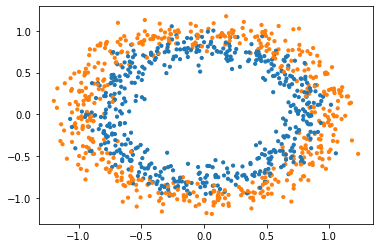

In [10]:
# generating data 
X, Y = make_circles(n_samples = 1000, noise = 0.1) 
# visualizing data 
colormap = np.array(['tab:orange', 'tab:blue'])
plt.scatter(X[:, 0], X[:, 1], c=colormap[Y], marker = '.', s=40) 
plt.show() 

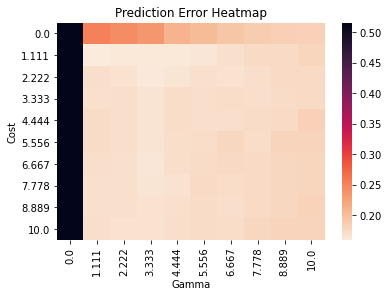

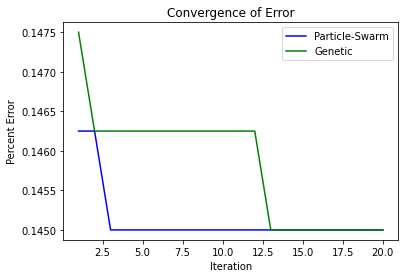

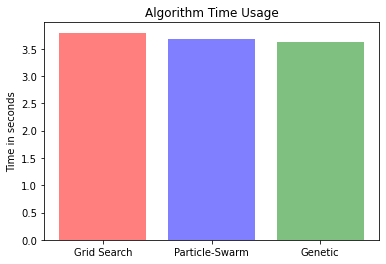

,best_param,vali_error,test_error,time
gs,"[1.1112, 1.1112]",0.15875,0.19,3.79343
ps,"[8.545221499998911, 6.892086825921353]",0.145,0.185,3.6737
ga,"[9.622435081939653, 6.792160377909775]",0.145,0.185,3.61737


In [40]:
''' tune with three algorithms on training dataset only'''''
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
res=tune(X_train, X_test, y_train, y_test,c_choices=False, gamma_choices=False)
pd.DataFrame(res).T

### b. single dataset with repeats

In [ ]:
def simulation(starting_size,ending_size,step_size,repeat,generation_func=None):
    size_list=np.arange(starting_size,ending_size+step_size,step_size)

    gs_test_errors,ps_test_errors,ga_test_errors=[],[],[]
    gs_times,ps_times,ga_times=[],[],[]

    for cur_size in tqdm(size_list):

        size_gs_test_errors,size_ps_test_errors,size_ga_test_errors=[],[],[]
        size_gs_times,size_ps_times,size_ga_times=[],[],[]

        for i in range(repeat):
            if generation_func is None:
                X, Y = make_circles(n_samples = cur_size, noise = 0.1) 
            else:
                X, Y = generation_func(cur_size,noise=0.2)
            
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
                      
            res=tune_cv(X_train,y_train,c_choices=False, gamma_choices=False,plot_converge=False,plot_time=False)

            #handle test_error
            cur_test_error_list=[]
            for cur_algo in ['gs','ps','ga']:
                temp_clf = svm.SVC(kernel='rbf',C=res[cur_algo]['best_param'][0],gamma=res[cur_algo]['best_param'][1])
                
                temp_clf.fit(X_train,y_train) 
                                
                cur_test_error_list.append(1-temp_clf.score(X_test,y_test))
            cur_test_error_list=cur_test_error_list/cur_test_error_list[0]*100 #scale error to relative percent
            size_gs_test_errors.append(cur_test_error_list[0])
            size_ps_test_errors.append(cur_test_error_list[1])
            size_ga_test_errors.append(cur_test_error_list[2])
            
            
            #handle time
            cur_time_list=[res['gs']['time'],res['ps']['time'],res['ga']['time']]
            size_gs_times.append(cur_time_list[0])
            size_ps_times.append(cur_time_list[1])
            size_ga_times.append(cur_time_list[2])

        #handle test error
        gs_test_errors.append(np.mean(size_gs_test_errors))
        ps_test_errors.append(np.mean(size_ps_test_errors))
        ga_test_errors.append(np.mean(size_ga_test_errors))

        #handle time
        gs_times.append(np.mean(size_gs_times))
        ps_times.append(np.mean(size_ps_times))
        ga_times.append(np.mean(size_ga_times))


    xs=np.repeat(size_list,repeat).tolist()*3
    temp=sum([gs_test_errors,ps_test_errors,ga_test_errors],[])
    ys=sum(temp,[])
    labs=np.repeat(['Grid Search','Particle-Swarm','Genetic'],repeat*len(size_list)).tolist()


    df_error = pd.DataFrame(np.array([xs, ys,labs]),
                       index=['Dataset Size','Percent Error Relative to Grid Search','Method'])
    
    #print(df_gs.T)
    df_error = df_error.T.astype({'Dataset Size': 'int32','Percent Error Relative to Grid Search':'float64','Method':'str'})

    df_error.to_pickle("testdf.pkl")
    g=sns.lineplot(data=df_error, x='Dataset Size', y='Percent Error Relative to Grid Search',hue="Method",style="Method",
    markers=True, dashes=False, ci=63,palette=["r", "b", "g"])
    plt.title('Testing Error Comparison')
    plt.show()


    plt.plot(size_list, gs_times, 'r',marker='o', label='Grid-Search')
    plt.plot(size_list, ps_times, 'b',marker='X', label='Particle-Swarm')
    plt.plot(size_list, ga_times, 'g',marker='s', label='Genetic')

    plt.title('Time Usage Comparison')
    plt.xlabel('Dataset Size')
    plt.ylabel('Run Time in secs')
    plt.legend()
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [25:00<00:00, 36.60s/it]


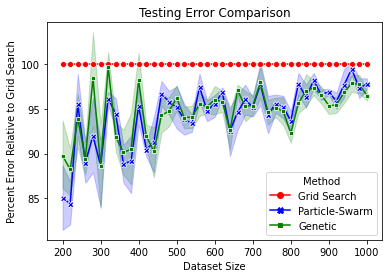

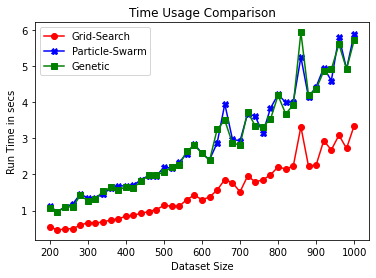

In [592]:
starting_size=200
ending_size=1000
step_size=20
repeat=5
simulation(starting_size,ending_size,step_size,repeat,generation_func = make_circles )

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:44<00:00,  5.58s/it]


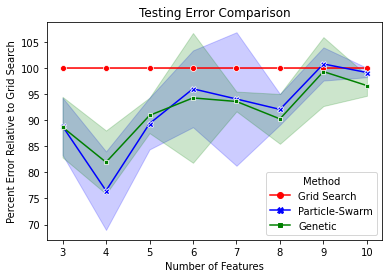

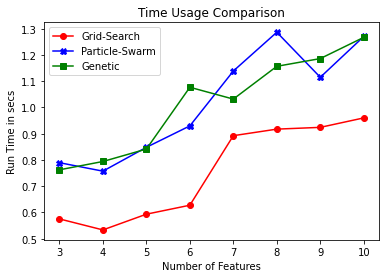

In [521]:
#test number of features
starting_size=3
ending_size=10
step_size=1
repeat=5
simulation(starting_size,ending_size,step_size,repeat,generation_func = make_classifications )

### Alternative plot

In [ ]:
def tune_cv(X_train, y_train,cv=5, c_choices=False, gamma_choices=False,plot_converge=True,plot_time=True):
    
    #give default hyperparameter choices
    if c_choices==False: c_choices=np.linspace(0.0001,10,8)
    if gamma_choices==False: gamma_choices=np.linspace(0.0001,10,8)
        
    #initialize lists to hold choices and errors
    gs_list_params, gs_list_errors=[],[]
    
    ps_list_params, ps_list_errors=[],[]
    
    ga_list_params, ga_list_errors=[],[]

    ps_converge_data, ga_converge_data=[],[]
    
    '''Tuning with Grid-Search'''
    param_grid = {'C': c_choices,  
              'gamma': gamma_choices}  
       
    cur_gs_res = grid_search(X_train,y_train, c_choices,gamma_choices,cv=cv,plot=False)
    gs_list_errors = cur_gs_res['final_error']
    gs_time = cur_gs_res['run_time']
    gs_list_params = cur_gs_res['best_params']
    ''''''
    
    if plot_converge:       
        pd_df=pd.DataFrame(cur_gs_res.cv_results_)
        pd_df['mean_test_score']=(1- pd_df['mean_test_score']) #change prediction score to prediciton error to be consistent
        
        pvt = pd.pivot_table(pd_df,values='mean_test_score', index='param_C', columns='param_gamma')
        
        ax = sns.heatmap(pvt,yticklabels=c_choices.round(3),xticklabels=gamma_choices.round(3),cmap = sns.cm.rocket_r)
        plt.xlabel("Gamma") 
        plt.ylabel("Cost") 
        ax.set_title('Prediction Error Heatmap')
    ''''''

    '''Tuning with Particle-Swarm Algorithm'''
    cur_ps_res=particle_swarm(X_train,y_train,cv=cv,plot=False)
    ps_list_params.append(cur_ps_res['params'])

    ps_list_errors.append(cur_ps_res['final_error'])
    ps_converge_data=cur_ps_res['error_list']
    ''''''

    '''Tuning with Genetic Algorithm'''
    cur_ga_res=genetic_algorithm(X_train,y_train,cv=cv,plot=False)
    ga_list_params.append(cur_ga_res['params'])

    ga_list_errors.append(cur_ga_res['final_error'])
    ga_converge_data=cur_ga_res['error_list']
    ''''''
    
    if plot_converge:
        ga_converge_data.pop(0)
        helper_plot_converge(ps_converge_data,ga_converge_data,len(ga_converge_data))
        
    if plot_time:
        helper_plot_time(gs_time,cur_ps_res['run_time'],cur_ga_res['run_time'])
        
    #find the the most optimal hyperparamter and error based on validation set
    gs_best_param, gs_min_error = gs_list_params,gs_list_errors
    ps_best_param, ps_min_error, ps_avg_error = helper_find_param_n_error(ps_list_params, ps_list_errors)
    ga_best_param, ga_min_error, ga_avg_error = helper_find_param_n_error(ga_list_params, ga_list_errors)

    return {'gs': {'best_param':gs_best_param,'vali_error':gs_min_error,'time':gs},'ps': {'best_param':ps_best_param,'vali_error':ps_min_error,'time':cur_ps_res['run_time']},'ga': {'best_param':ga_best_param,'vali_error':ga_min_error,'time':cur_ga_res['run_time']}}

In [ ]:
'''repeat multiple times for each size'''
def simulation(starting_size,ending_size,step_size,size_list=None,repeat,generation_func=None):
    size_list=np.arange(starting_size,ending_size+step_size,step_size)
    if size_list is not None: size_list=size_list
    
    gs_test_errors,ps_test_errors,ga_test_errors=[],[],[]
    gs_times,ps_times,ga_times=[],[],[]


    for cur_size in tqdm(size_list):

        size_gs_test_errors,size_ps_test_errors,size_ga_test_errors=[],[],[]
        size_gs_times,size_ps_times,size_ga_times=[],[],[]

        for i in range(repeat):
            X, Y = generation_func(cur_size,noise=0.2)
            #X, Y = make_classification(n_samples=cur_size, n_features=11, n_informative=8, n_redundant=2, n_repeated=1, n_classes=2, n_clusters_per_class=1,class_sep=1,flip_y=0.3,weights=[0.5,0.5])
            #X, Y = my_generate(cur_size)
            
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)         
            res=tune_cv(X_train,y_train,c_choices=False, gamma_choices=False,plot_converge=False,plot_time=False)

            #handle test_error
            cur_test_error_list=[]

            for cur_algo in ['gs','ps','ga']:
                temp_clf = svm.SVC(kernel='rbf',C=res[cur_algo]['best_param'][0],gamma=res[cur_algo]['best_param'][1])
                
                temp_clf.fit(X_train,y_train) 
                
                cur_test_error_list.append(1-temp_clf.score(X_test,y_test))
            cur_test_error_list=cur_test_error_list/cur_test_error_list[0]*100 #scale error to relative percent
            size_gs_test_errors.append(cur_test_error_list[0])
            size_ps_test_errors.append(cur_test_error_list[1])
            size_ga_test_errors.append(cur_test_error_list[2])


            #handle time
            cur_time_list=[res['gs']['time'],res['ps']['time'],res['ga']['time']]
            size_gs_times.append(cur_time_list[0])
            size_ps_times.append(cur_time_list[1])
            size_ga_times.append(cur_time_list[2])

        #handle test error
        gs_test_errors.append(np.mean(size_gs_test_errors))
        ps_test_errors.append(np.mean(size_ps_test_errors))
        ga_test_errors.append(np.mean(size_ga_test_errors))

        #handle time
        gs_times.append(np.mean(size_gs_times))
        ps_times.append(np.mean(size_ps_times))
        ga_times.append(np.mean(size_ga_times))

    #plt.plot(size_list, gs_times, 'r', label='Grid-Search')
    z = np.polyfit(size_list, gs_times, 3)
    plt.plot(size_list,np.poly1d(z)(size_list),color='r',linewidth=2.0,label='Grid-Search')
    #plt.plot(size_list, ps_times, 'b', label='Particle-Swarm')
    z = np.polyfit(size_list, ps_times, 3)
    plt.plot(size_list,np.poly1d(z)(size_list),color='b',linewidth=2.0, label='Particle-Swarm')
    #plt.plot(size_list, ga_times, 'g', label='Genetic')
    z = np.polyfit(size_list, ga_times, 3)
    plt.plot(size_list,np.poly1d(z)(size_list),color='g',linewidth=2.0, label='Genetic')

    plt.title('Time Usage in Different Size Dataset')
    plt.xlabel('Data Size')
    plt.ylabel('Run Time in secs')
    plt.legend()
    plt.show()


    plt.plot(size_list, gs_test_errors, 'ro',alpha=0.5,markersize=2)
    z = np.polyfit(size_list, gs_test_errors, 3)
    plt.plot(size_list,np.poly1d(z)(size_list),color='r',linewidth=2.0,label='Grid-Search')


    plt.plot(size_list, ps_test_errors, 'bo',alpha=0.5,markersize=2)
    z = np.polyfit(size_list, ps_test_errors, 3)
    plt.plot(size_list,np.poly1d(z)(size_list),color='b',linewidth=2.0, label='Particle-Swarm')

    plt.plot(size_list, ga_test_errors, 'go',alpha=0.5,markersize=2)
    z = np.polyfit(size_list, ga_test_errors, 3)
    plt.plot(size_list,np.poly1d(z)(size_list),color='g',linewidth=2.0, label='Genetic')


    plt.title('Test Error Comparison')
    plt.xlabel('Data Size')
    plt.ylabel('Test Error')
    plt.legend()
    plt.show()
    
    index = size_list

    time_df = pd.DataFrame({'Grid Search': gs_times,'Particle Swarm': ps_times, 'Genetic Algorithm':ga_times}, index=index)
    ax =time_df.plot(kind='bar', figsize=(15, 4),title='Time Usage',rot=1,color=['lightcoral', 'cornflowerblue', 'mediumseagreen'])
    plt.sca(ax)
        
    test_error_df = pd.DataFrame({'Grid Search': gs_test_errors,'Particle Swarm': ps_test_errors, 'Genetic Algorithm':ga_test_errors}, index=index)
    ax =test_error_df.plot(kind='bar', figsize=(15, 4),title='Test ERROR',rot=1,color=['lightcoral', 'cornflowerblue', 'mediumseagreen'])
    ax.set_ylim(75,110)
    plt.sca(ax)    
    
    

100%|██████████| 4/4 [01:23<00:00, 20.99s/it]
2021-03-11 10:39:04,868 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


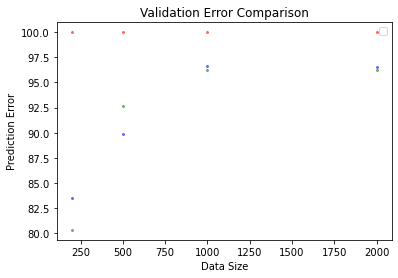

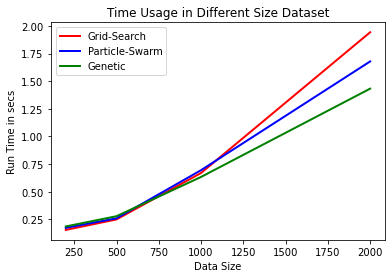

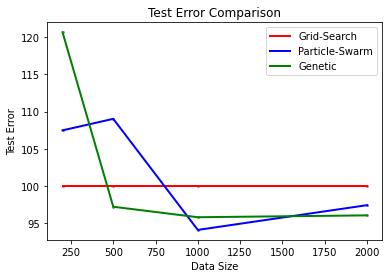

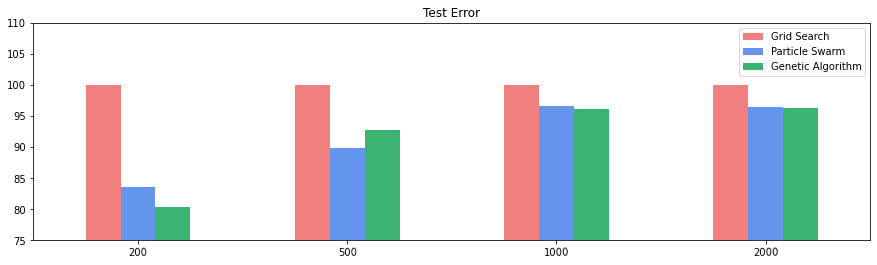

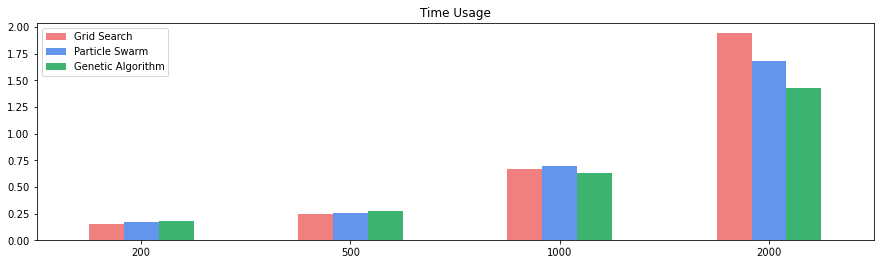

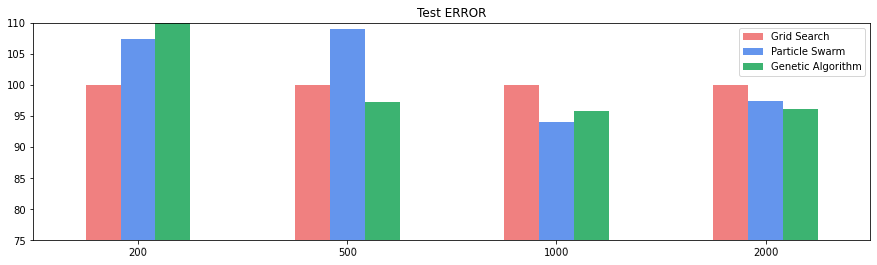

In [84]:
starting_size=100
ending_size=2000
step_size=250
repeat=10

size_list=[200,500,1000,2000]
simulation(starting_size,ending_size,step_size,repeat,generation_func = make_circles )

## Part 4: Combination of GS and GA in real dataset

In [525]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib import pyplot
from pprint import pprint
from IPython.display import display 
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import RandomizedSearchCV

### Load Data

In [526]:
#%% Read raw data 
data_raw = pd.read_csv('BankChurners.csv')
# Columns to be dropped
drop_columns = ['CLIENTNUM',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

# Remove CLIENTNUM and the Naive_Bayes_Classifiers
data_raw = data_raw.drop(drop_columns,errors='ignore',axis=1)
# Initial glance at data
display(data_raw.info(verbose = True,null_counts=False))
# Check for missing or NaN data 
print("No Missing Data in this Dataset")
print(data_raw.isnull().sum())
print(data_raw.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Attrition_Flag            object 
 1   Customer_Age              int64  
 2   Gender                    object 
 3   Dependent_count           int64  
 4   Education_Level           object 
 5   Marital_Status            object 
 6   Income_Category           object 
 7   Card_Category             object 
 8   Months_on_book            int64  
 9   Total_Relationship_Count  int64  
 10  Months_Inactive_12_mon    int64  
 11  Contacts_Count_12_mon     int64  
 12  Credit_Limit              float64
 13  Total_Revolving_Bal       int64  
 14  Avg_Open_To_Buy           float64
 15  Total_Amt_Chng_Q4_Q1      float64
 16  Total_Trans_Amt           int64  
 17  Total_Trans_Ct            int64  
 18  Total_Ct_Chng_Q4_Q1       float64
 19  Avg_Utilization_Ratio     float64
dtypes: float64(5), int64(9), obj

None

No Missing Data in this Dataset
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64
      Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F  

### Clean Data

In [527]:
# convert bool and object to category 
cat_types = ['bool','object','category']
data_clean = data_raw.copy()
data_clean[data_clean.select_dtypes(cat_types).columns] = data_clean.select_dtypes(cat_types).apply(lambda x: x.astype('category'))

#%% Initial glance at cleaned data
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           10127 non-null  category
 5   Marital_Status            10127 non-null  category
 6   Income_Category           10127 non-null  category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

In [528]:
#%% Split data_clean into two datasets y - depedent variable, x - independent variables 
# Map Attrited Customer = 1 and Existing Customer = 0
codes = {'Existing Customer':0, 'Attrited Customer':1}
data_clean['Attrition_Flag'] = data_clean['Attrition_Flag'].map(codes)

y = data_clean['Attrition_Flag']
X = data_clean.drop('Attrition_Flag',errors='ignore',axis=1)


### Label Encoding

In [529]:
for col in X.select_dtypes('category').columns.to_list():
    print(col + ': '+ str(X[col].cat.categories.to_list()))

# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python 
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = X.select_dtypes('category').columns.to_list()
for feature in features_to_encode:
    X = encode_and_bind(X, feature)
    
X.info()

Gender: ['F', 'M']
Education_Level: ['College', 'Doctorate', 'Graduate', 'High School', 'Post-Graduate', 'Uneducated', 'Unknown']
Marital_Status: ['Divorced', 'Married', 'Single', 'Unknown']
Income_Category: ['$120K +', '$40K - $60K', '$60K - $80K', '$80K - $120K', 'Less than $40K', 'Unknown']
Card_Category: ['Blue', 'Gold', 'Platinum', 'Silver']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_Age                    10127 non-null  int64  
 1   Dependent_count                 10127 non-null  int64  
 2   Months_on_book                  10127 non-null  int64  
 3   Total_Relationship_Count        10127 non-null  int64  
 4   Months_Inactive_12_mon          10127 non-null  int64  
 5   Contacts_Count_12_mon           10127 non-null  int64  
 6   Credit_Limit                    10127 non-null  f

In [571]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle= True,stratify = y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2, shuffle= True,stratify = y_test)

In [575]:
def tune_cv(X_train, y_train,cv=5, c_choices=False, gamma_choices=False,plot_converge=True,plot_time=True):
    
    #give default hyperparameter choices
    if c_choices==False: c_choices=[2**n for n in [-11,-9,-7,-5,-3,-1,0,1,3,5,7,9,11,13,15]]  #np.linspace(2,2**15,15)#c_choices=
    if gamma_choices==False: gamma_choices=[2**n for n in [-11,-9,-7,-3,-1,0,1,3,5,7,9,11,13,15]]  #np.linspace(2**-11,2**-9,15)#
        
    #initialize lists to hold choices and errors
    gs_list_params, gs_list_errors=[],[]
    ps_list_params, ps_list_errors=[],[]
    ga_list_params, ga_list_errors=[],[]
    ps_converge_data, ga_converge_data=[],[]
    
    '''Tuning with Grid-Search'''
    param_grid = {'C': c_choices,  
              'gamma': gamma_choices}  
    
    #print("cv is kfold: ",cv)
    time_start = time.perf_counter()
    
    cur_gs_res = GridSearchCV(svm.SVC(kernel='rbf'), param_grid,cv=cv) 
    
    cur_gs_res.fit(X_train,y_train)
    gs_time = (time.perf_counter() - time_start)
    
    gs_list_params=np.asarray([cur_gs_res.best_estimator_.get_params()['C'],cur_gs_res.best_estimator_.get_params()['gamma']])
    gs_list_errors=(1-cur_gs_res.best_score_)
        
    if plot_converge:       
        
        pd_df=pd.DataFrame(cur_gs_res.cv_results_)
        pd_df['mean_test_score']=(1- pd_df['mean_test_score']) #change prediction score to prediciton error to be consistent
        
        pvt = pd.pivot_table(pd_df,values='mean_test_score', index='param_C', columns='param_gamma')
                
        ax = sns.heatmap(pvt,yticklabels=[-11,-9,-7,-5,-3,-1,0,1,3,5,7,9,11,13,15],xticklabels=[-11,-9,-7,-5,-3,-1,0,1,3,5,7,9,11,13,15],cmap = sns.cm.rocket_r)
        #plt.yscale('log',base=2) 
        plt.xlabel("Gamma, log base 2") 
        plt.ylabel("Cost, log base 2") 
        ax.set_title('Prediction Error Heatmap')
    ''''''

    '''Tuning with Particle-Swarm Algorithm'''
    cur_ps_res=particle_swarm(X_train,y_train,cv=cv,plot=False)
    ps_list_params.append(cur_ps_res['params'])

    ps_list_errors.append(cur_ps_res['final_error'])
    ps_converge_data=cur_ps_res['error_list']
    ''''''

    '''Tuning with Genetic Algorithm'''
    cur_ga_res=genetic_algorithm(X_train,y_train,cv=cv,plot=False)
    ga_list_params.append(cur_ga_res['params'])

    ga_list_errors.append(cur_ga_res['final_error'])
    ga_converge_data=cur_ga_res['error_list']
    ''''''
    
    if plot_converge:
        ga_converge_data.pop(0)
        helper_plot_converge(ps_converge_data,ga_converge_data,len(ga_converge_data))
        
    if plot_time:
        helper_plot_time(gs_time,cur_ps_res['run_time'],cur_ga_res['run_time'])
        
    #find the the most optimal hyperparamter and error based on validation set
    gs_best_param, gs_min_error = gs_list_params,gs_list_errors
    ps_best_param, ps_min_error, ps_avg_error = helper_find_param_n_error(ps_list_params, ps_list_errors)
    ga_best_param, ga_min_error, ga_avg_error = helper_find_param_n_error(ga_list_params, ga_list_errors)

    return {'gs': {'best_param':gs_best_param,'vali_error':gs_min_error,'time':gs_time},'ps': {'best_param':ps_best_param,'vali_error':ps_min_error,'time':cur_ps_res['run_time']},'ga': {'best_param':ga_best_param,'vali_error':ga_min_error,'time':cur_ga_res['run_time']}}

this is on the second grid part

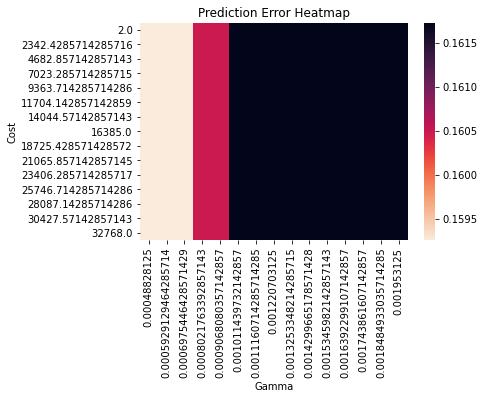

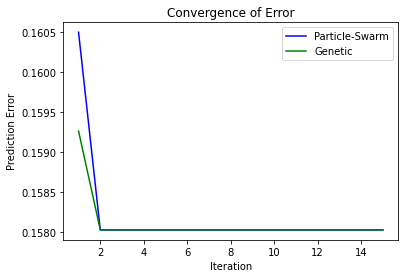

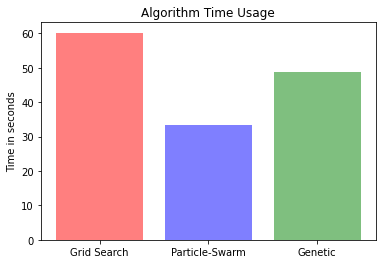

,best_param,vali_error,time
gs,"[2.0, 0.00048828125]",0.159259,60.1761
ps,"[21467.6381582285, 0.0005231044380330507]",0.158025,33.3103
ga,"[27578.77134586433, 0.0007917915021089988]",0.158025,48.6492


In [295]:
res=tune_cv(X_train,y_train,c_choices=False, gamma_choices=False)
pd.DataFrame(res).T

## Breast Cancer Dataset

In [240]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True,stratify = y)
X_train.shape

(455, 30)

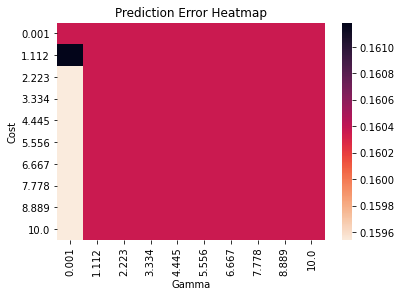

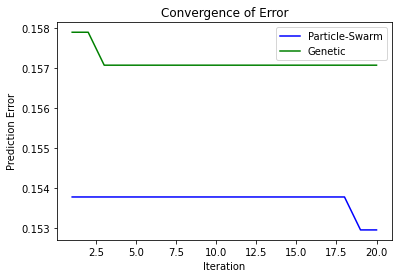

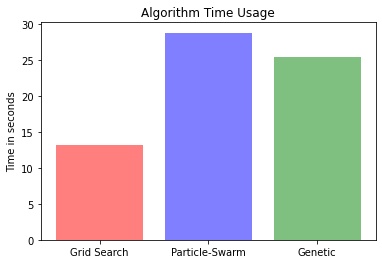

,best_param,vali_error,time
gs,"[2.223, 0.001]",0.159539,13.1151
ps,"[4.523278644328683, 9.150767207999368e-05]",0.152961,28.7825
ga,"[3.2456866534714846, 0.0003035972828818455]",0.157072,25.3795


In [270]:
res=tune_cv(X_train,y_train,c_choices=False, gamma_choices=False)
pd.DataFrame(res).T